In [3]:
# General Libs
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop

from sklearn.model_selection import train_test_split
import shutil
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:

import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
im_shape = (200,200)

base_dir = './classification_dataset/dataset'
train_dir = './classification_dataset/train'
test_dir = './classification_dataset/test'
TRAINING_DIR = './classification_dataset/train'
TEST_DIR = './classification_dataset/test'

seed = 10

EPOCHS = 150
BATCH_SIZE = 16

In [27]:
# Normalizar os caminhos
base_dir = os.path.normpath(base_dir)
train_dir = os.path.normpath(train_dir)
test_dir = os.path.normpath(test_dir)

# Criação das pastas de treino, validação e teste
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [29]:
# Processamento de todas as imagens nas subpastas
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    folder_path = os.path.normpath(folder_path) 
    
    
    train_dir_aux = os.path.join(train_dir, folder)
    train_dir_aux = os.path.normpath(train_dir_aux)
    
    test_dir_aux = os.path.join(test_dir, folder)
    test_dir_aux = os.path.normpath(test_dir_aux)
    
    os.makedirs(test_dir_aux, exist_ok=True)
    os.makedirs(train_dir_aux, exist_ok=True)
    
    
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        
        # Divide em treino (70%), teste (30%)
        train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
        
        # Mover imagens de treino
        for image_file in train_images:
            shutil.copy(os.path.join(folder_path, image_file), os.path.join(train_dir_aux, image_file))
        
        # Mover imagens de teste
        for image_file in test_images:
            shutil.copy(os.path.join(folder_path, image_file), os.path.join(test_dir_aux, image_file))

print("Processo de divisão e aumento de dados completo!")

Processo de divisão e aumento de dados completo!


In [47]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [48]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 1714 images belonging to 5 classes.
Found 426 images belonging to 5 classes.
Found 919 images belonging to 5 classes.
Classes: ['10', '100', '25', '5', '50']


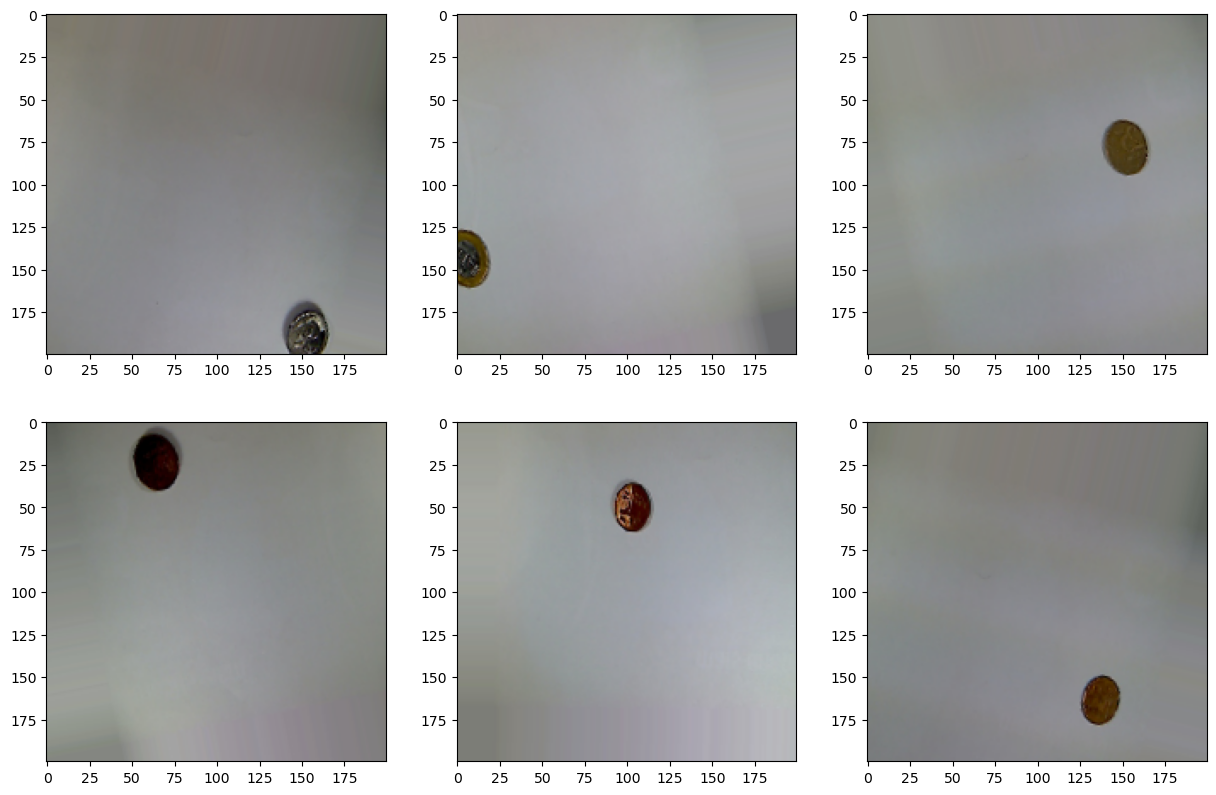

In [49]:
# Visualizing some examples
plt.figure(figsize=(15,15))
for i in range(6):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.__next__()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [50]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(im_shape[0],im_shape[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

In [51]:
#Callback to save the best model 
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.keras',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,verbose=1)
]

#Training
history = model.fit(
            train_generator,
            steps_per_epoch=nb_train_samples // BATCH_SIZE,
            epochs=EPOCHS,
            callbacks = callbacks_list,
            validation_data=validation_generator,
            verbose = 1,
            validation_steps=nb_validation_samples // BATCH_SIZE
        )

Epoch 1/150
107/107 [==============================] - ETA: 0s - loss: 1.7277 - accuracy: 0.1932
Epoch 1: val_loss improved from inf to 1.60907, saving model to model.keras
107/107 [==============================] - 30s 187ms/step - loss: 1.7277 - accuracy: 0.1932 - val_loss: 1.6091 - val_accuracy: 0.1947
Epoch 2/150
107/107 [==============================] - ETA: 0s - loss: 1.6337 - accuracy: 0.2244
Epoch 2: val_loss improved from 1.60907 to 1.57425, saving model to model.keras
107/107 [==============================] - 20s 186ms/step - loss: 1.6337 - accuracy: 0.2244 - val_loss: 1.5742 - val_accuracy: 0.3606
Epoch 3/150
107/107 [==============================] - ETA: 0s - loss: 1.5069 - accuracy: 0.3504
Epoch 3: val_loss improved from 1.57425 to 1.39301, saving model to model.keras
107/107 [==============================] - 20s 183ms/step - loss: 1.5069 - accuracy: 0.3504 - val_loss: 1.3930 - val_accuracy: 0.3486
Epoch 4/150
107/107 [==============================] - ETA: 0s - loss: 

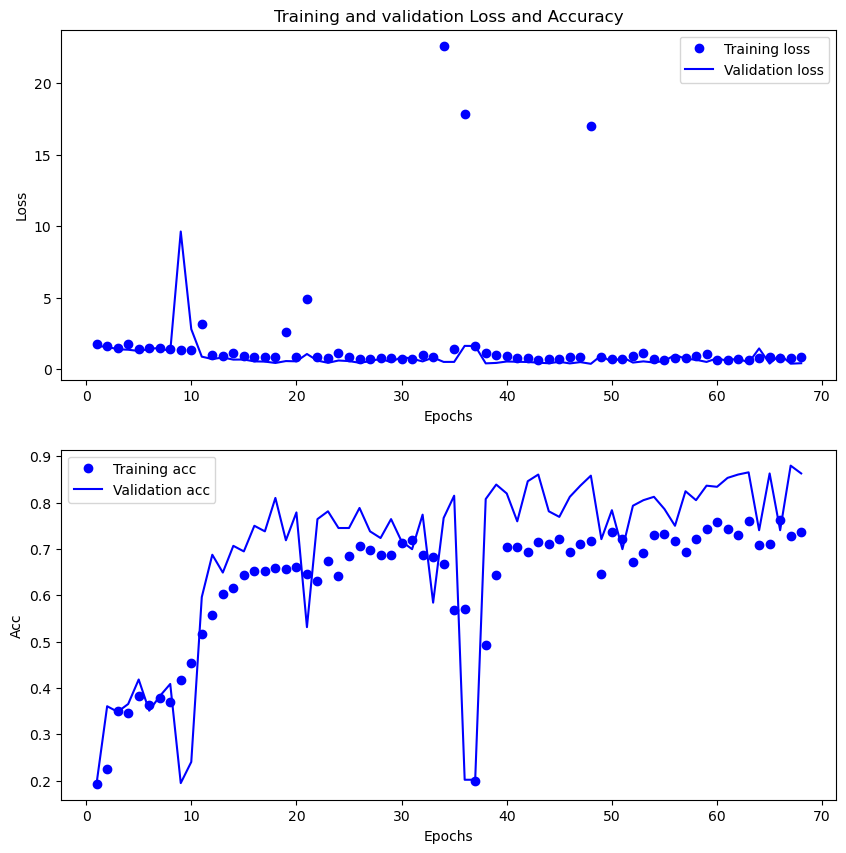

In [52]:
# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Evaluating the model

In [58]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('model.keras')
model.save('./best_result/model.h5')

In [54]:
# Using the validation dataset
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

27/27 [==============================] - 3s 79ms/step - loss: 0.3684 - accuracy: 0.8615
Val loss: 0.3684338629245758
Val accuracy: 0.8615023493766785


In [55]:
# Using the test dataset
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

58/58 [==============================] - 4s 71ms/step - loss: 0.3868 - accuracy: 0.8455
Test loss: 0.3868370056152344
Test accuracy: 0.84548419713974


In [73]:
labels_prediction = list(test_generator.class_indices.keys())
labels_prediction

['10', '100', '25', '5', '50']

In [56]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

58/58 [==============================] - 4s 70ms/step
Classification Report
              precision    recall  f1-score   support

          10       0.71      0.60      0.65       181
         100       0.97      0.99      0.98       183
          25       0.66      0.76      0.71       182
           5       0.91      0.92      0.91       180
          50       0.98      0.95      0.97       193

    accuracy                           0.85       919
   macro avg       0.85      0.84      0.84       919
weighted avg       0.85      0.85      0.84       919



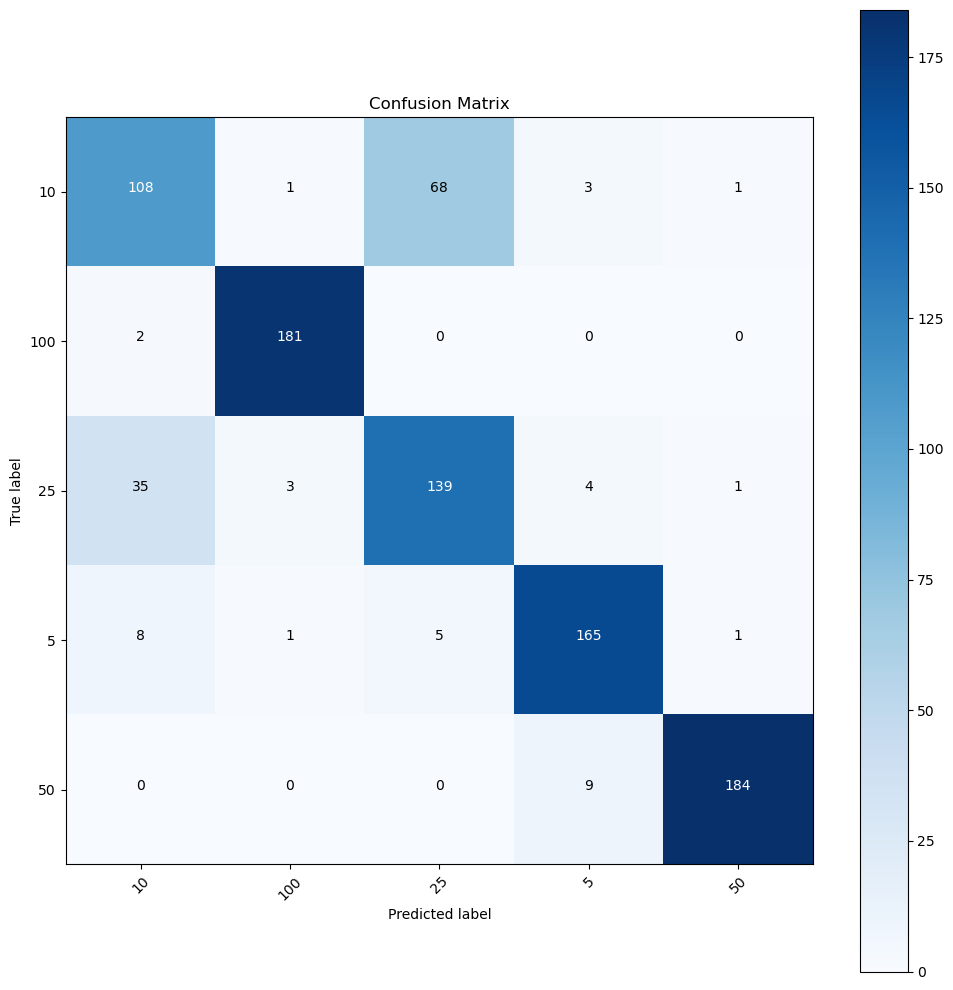

In [57]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#On test dataset
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [75]:
# Parâmetros
input_shape = (200, 200)  # Substitua pelo tamanho esperado pelo seu modelo

# Iniciar a captura da câmera
cap = cv2.VideoCapture(0)  # '0' geralmente é a câmera padrão. Pode ser ajustado para outra fonte.

while True:
    # Captura frame a frame
    ret, frame = cap.read()
    if not ret:
        break

    # Pre-processamento da imagem
    img = cv2.resize(frame, input_shape)
    img = img.astype('float32') / 255.0  # Normaliza para 0-1
    img = np.expand_dims(img, axis=0)    # Adiciona dimensão de lote (batch)

    # Fazer previsão com o modelo
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)

    # Exibir o resultado no frame
    cv2.putText(frame, f'Class: {labels_prediction[predicted_class[0]]}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Exibir o frame
    cv2.imshow('Camera', frame)

    # Sair com a tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libere a captura e feche as janelas
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 23ms/step
